In [92]:
%config InlineBackend.figure_format = 'retina'

In [93]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sys import setrecursionlimit
import threading
setrecursionlimit(10 ** 9)
threading.stack_size(67108864)

67108864

# **Numerical differentiation and integration**

### **#0** ***Введение, проверка работоспособности минимального функционала и средств Python***

Пусть на отрезке $[a, b]$ задана функция $f(x)$.


Необходимо выбрать шаг сетки $h > 0$.

После расчета значения производной в точке можно варьировать параметр шага сетки и следить, как будет изменяться абсолютная погрешность. С точки зрения классической теории, при увеличении порядка малости этого параметра предельная абсолютная погрешность должна тоже уменьшаться.

Однако, как покажет эксперимент, последнее утверждение неверно.

In [94]:
h = 2e-1

Зададим функцию $f(x)=x^2\cdot e^{\sin x}, \: \: x \in [10, 40]$

In [95]:
def func_first(x):
    return x ** 2 * np.e ** np.sin(x)

a, b = 10, 40

При этом количество узлов сетки можно посчитать в виде: $n=\frac{b-a}{h}$

In [96]:
n = int((b - a) / h)
print(f'Quantity of points in interval: {n}')

Quantity of points in interval: 150


Удостоверимся, что <code>np.linspace</code> не чудит и выполняет поставленную задачу в точности как генератор. 

Необходимо разбить отрезок на $n+1$ значений, отделнных параметризованным шагом $h$.

In [97]:
# numpy arithmetic
argx = np.linspace(a, b, n + 1)
# lst generator arithmetic
argx_generator = [a + h * i for i in range(n + 1)]
print(f'Arithmetic summary error: {sum([abs(v1 - v2) for v1, v2 in zip(argx, argx_generator)])}')

argf = [func_first(point) for point in argx]

Arithmetic summary error: 0.0


Далее просто построим пары (точка, значение в точке) для определенной ранее функции:

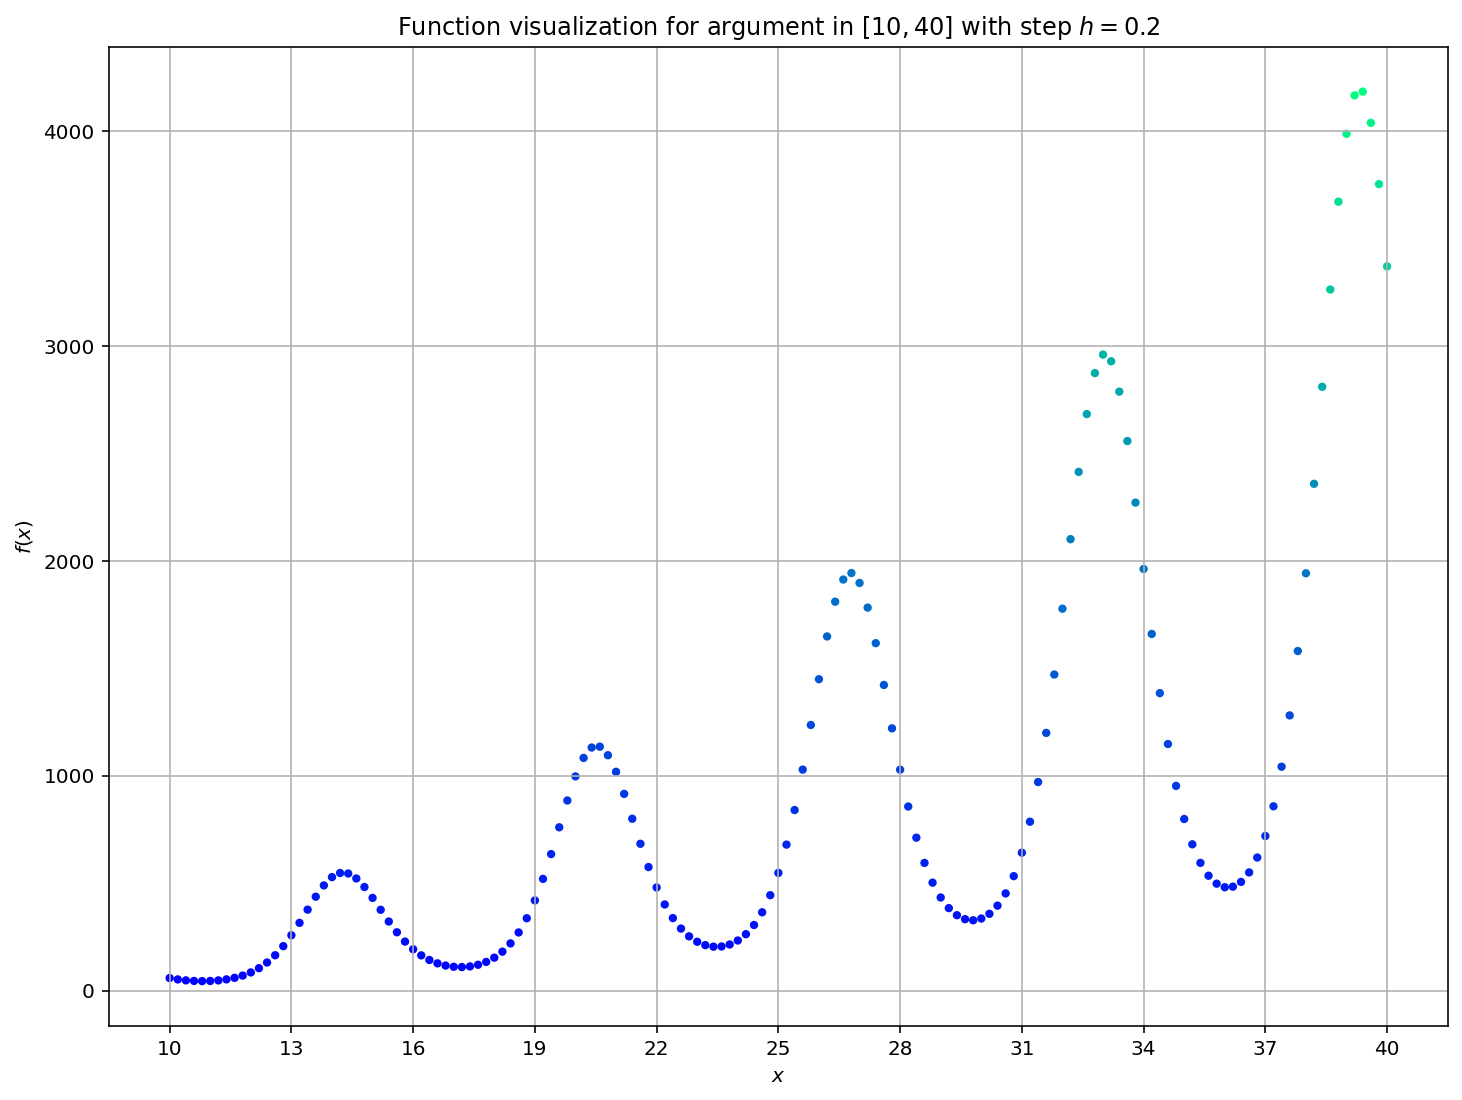

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
ax.scatter(x=argx, y=argf, c=argf, cmap=cm.winter, s=10)
ax.grid()
ax.set(title=f'Function visualization for argument in $[{a}, {b}]$ with step $h={h}$',
       xlabel='$x$', ylabel='$f(x)$',
       xticks=np.arange(a, b + 1, int((b - a) / 9)))
plt.show()

### **#1** ***Реализовать методы нахождения производной при фиксированном значении шага.***

Для начала посмотрим на ***правые значения производной***: 

$f'(x) \approx\frac{f(x+h)-f(x)}{h}$

Обратим внимание на метод <code>get_rightdiff_memoization</code>, где выполнена оптимизация по вызову искомых расчетных функций.



In [99]:
def get_rightdiff_atpoint(function, argument, h):
    return (function(argument + h) - function(argument)) / h

def get_rightdiff(function, arguments, h):
    return [get_rightdiff_atpoint(function, x, h) for x in arguments]

# with memoization 
def get_rightdiff_memoization(function, arguments, h):
    argf = [function(arg) for arg in arguments]
    if len(argf) == 0: 
        return []
    if len(argf) == 1:
        return [get_rightdiff_atpoint(function, arguments[0], h)]
    return [(argf[i + 1] - argf[i]) / h for i in range(len(argf) - 1)] + [get_rightdiff_atpoint(function, arguments[-1], h)]

Аналогично для ***левых значений производной***:

$f'(x) \approx \frac{f(x)-f(x-h)}{h}$

In [100]:
def get_leftdiff_atpoint(function, argument, h):
    return (function(argument) - function(argument - h)) / h

def get_leftdiff(function, arguments, h):
    return [get_leftdiff_atpoint(function, x, h) for x in arguments]

# with memoization 
def get_leftdiff_memoization(function, arguments, h):
    argf = [function(arg) for arg in arguments]
    if len(argf) == 0: 
        return []
    if len(argf) == 1:
        return [get_leftdiff_atpoint(function, arguments[0], h)]
    return [get_leftdiff_atpoint(function, arguments[0], h)] + [(argf[i] - argf[i - 1]) / h for i in range(1, len(argf))]

Однако для повышения точности можно задействовать тройки узловых значений $y'_i=\frac{y_{i+1}-y_{i-1}}{2h}$, а для первого и последенего значений соответсвенно $y_0'=\frac{-3y_0+4y_1-y_2}{2h}$ и $y_n'=\frac{y_{n-2}-4y_{n-1}+3y_n}{2h}$.

Данный подход называется ***центральной разностной производной*** (со вторым порядком точности).

In [101]:
def get_diff_atpoint(function, argument, h):
    return (function(argument + h) - function(argument - h)) / (2 * h)

def get_diff(function, arguments, h):
    return [get_diff_atpoint(function, x, h) for x in arguments]

# with memoization 
def get_diff_memoization(function, arguments, h):
    argf = [function(arg) for arg in arguments]
    if len(argf) == 0: 
        return []
    if len(argf) < 3:
        return [get_diff_atpoint(function, arguments[0], h)]
    return [(-3 * argf[0] + 4 * argf[1] - argf[2]) / (2 * h)] + [(argf[i + 1] - argf[i - 1]) / (2 * h) for i in range(1, len(argf) - 1)] + [(argf[-3] - 4 * argf[-2] + 3 * argf[-1]) / (2 * h)]

### **#2** ***Возьмите 2 произвольные функции. Вычислите аналитически производные этих функций. Постройте их графики, а также вычисленные значения численной производной в узлах сетки.***

Зададим функции:

$f_1(x)=x^2\cdot e^{\sin x}, \: \: x \in [10, 40]$

$f_2(x)=\ln x \cdot e^{\sin x}, \: \: x \in [10, 40]$

In [102]:
a, b = 10, 40

In [103]:
h = 2e-1
argx = np.linspace(a, b, int((b - a) / h) + 1)

In [104]:
def func_first(x):
    return x ** 2 * np.e ** np.sin(x)
def func_second(x):
    return np.log(x) * np.e ** np.sin(x)

Построим графики обеих функций:


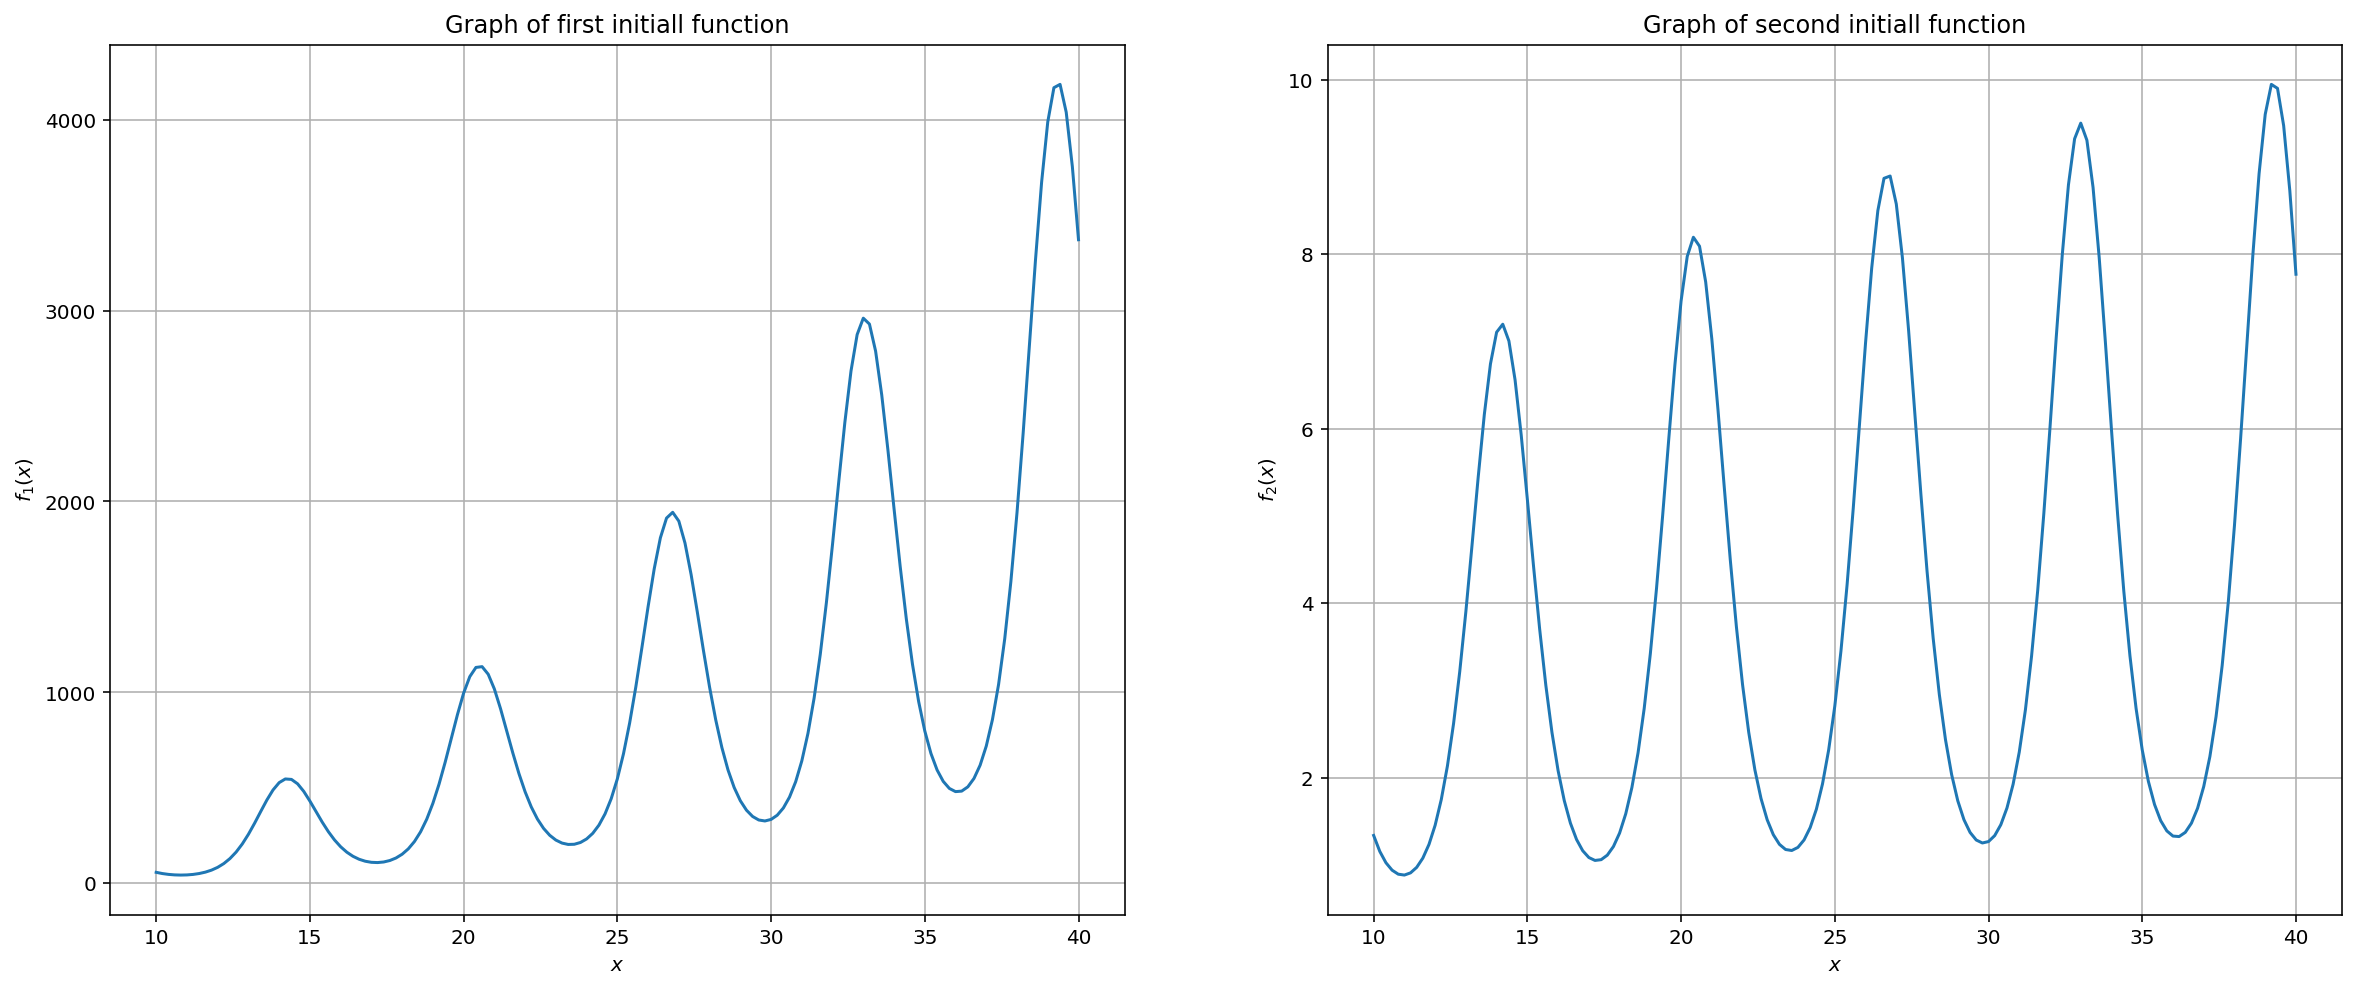

In [105]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(argx, func_first(argx))
ax[1].plot(argx, func_second(argx))
ax[0].grid()
ax[1].grid()
ax[0].set(title=f'Graph of first initiall function', xlabel='$x$', ylabel="$f_1(x)$")
ax[1].set(title=f'Graph of second initiall function', xlabel='$x$', ylabel="$f_2(x)$")
plt.show()

Аналитически вычислим численные значения производной в узлах сетки для обеих функций:

In [106]:
def func_derivative_first(x):
    return np.e ** np.sin(x) * (2 * x + x ** 2 * np.cos(x))

def func_derivative_second(x):
    return np.e ** np.sin(x) * (1 / x + np.log(x) * np.cos(x))

In [107]:
analyticdiff_first = func_derivative_first(argx)
analyticdiff_second = func_derivative_second(argx)

Нанесем на график аналитически полученные значения производных в узлах сетки:

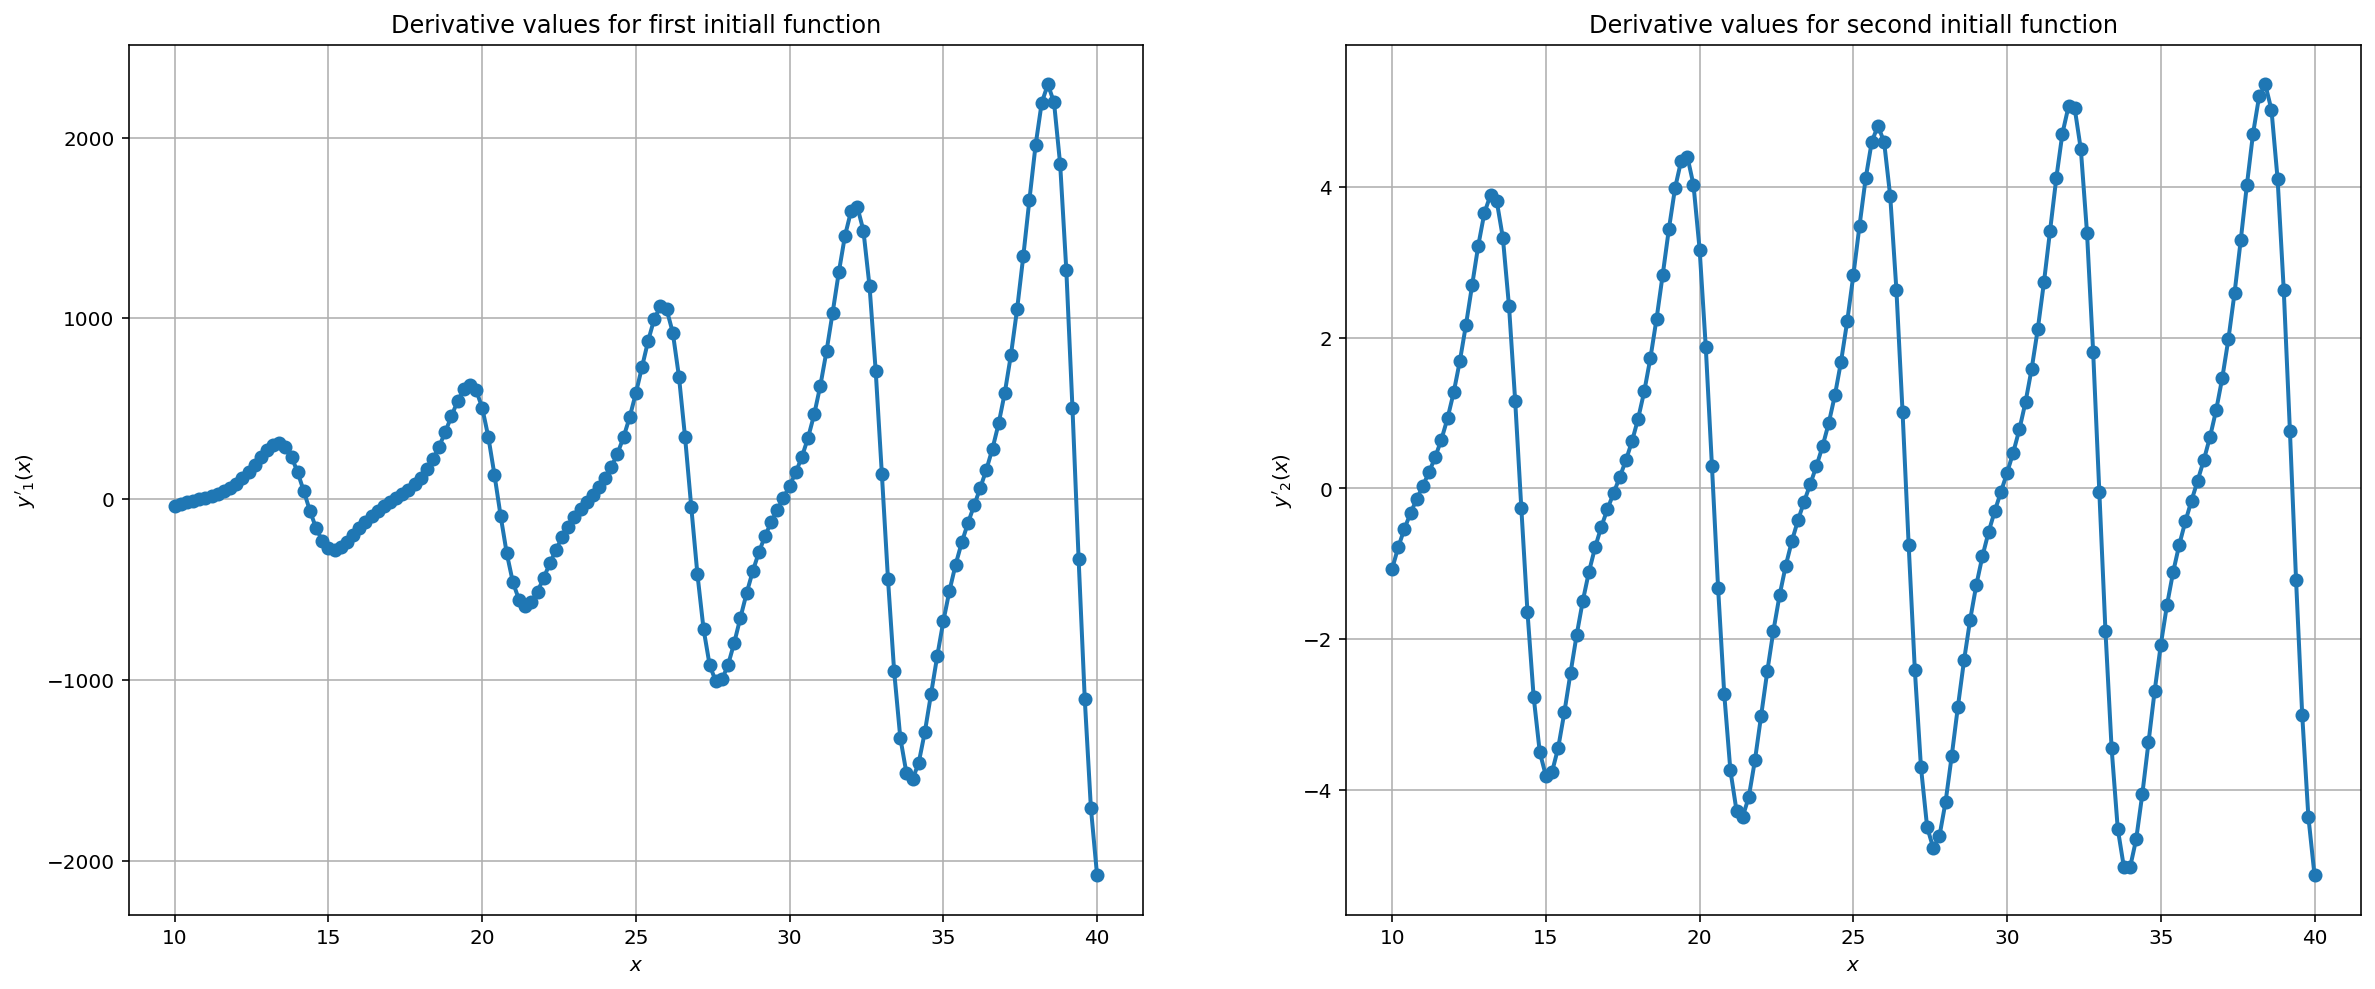

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(argx, analyticdiff_first, 'o-', linewidth=2)
ax[1].plot(argx, analyticdiff_second, 'o-', linewidth=2)
ax[0].grid()
ax[1].grid()
ax[0].set(title=f'Derivative values for first initiall function', xlabel='$x$', ylabel="$y'_1(x)$")
ax[1].set(title=f'Derivative values for second initiall function', xlabel='$x$', ylabel="$y'_2(x)$")
plt.show()

Найдем значения производной по всем представленным методам для обеих функций:

In [109]:
# first function
rightdiff_first = get_rightdiff(func_first, argx, h)
leftdiff_first = get_leftdiff(func_first, argx, h)
diff_first = get_diff(func_first, argx, h)
# first function, with memoization
rightdiff_memoization_first = get_rightdiff_memoization(func_first, argx, h)
leftdiff_memoization_first = get_leftdiff_memoization(func_first, argx, h)
diff_memoization_first = get_diff_memoization(func_first, argx, h)

# second function
rightdiff_second = get_rightdiff(func_second, argx, h)
leftdiff_second = get_leftdiff(func_second, argx, h)
diff_second = get_diff(func_second, argx, h)
# second function, with memoization
rightdiff_memoization_second = get_rightdiff_memoization(func_second, argx, h)
leftdiff_memoization_second = get_leftdiff_memoization(func_second, argx, h)
diff_memoization_second = get_diff_memoization(func_second, argx, h)

In [110]:
def plot_compare(derivpairs, arguments, h):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    for i in range(len(derivpairs)):
        ax.scatter(arguments, derivpairs[i][0], label=f"{derivpairs[i][1]} method", s=50)
    ax.grid()
    ax.legend()
    ax.set(title=f'Comparison of derivative values with step $h={h}$',
           xlabel='$x$', ylabel="$y'(x)$")
    plt.show()

Сравним последние $3$ значения для производных в узлах сетки:

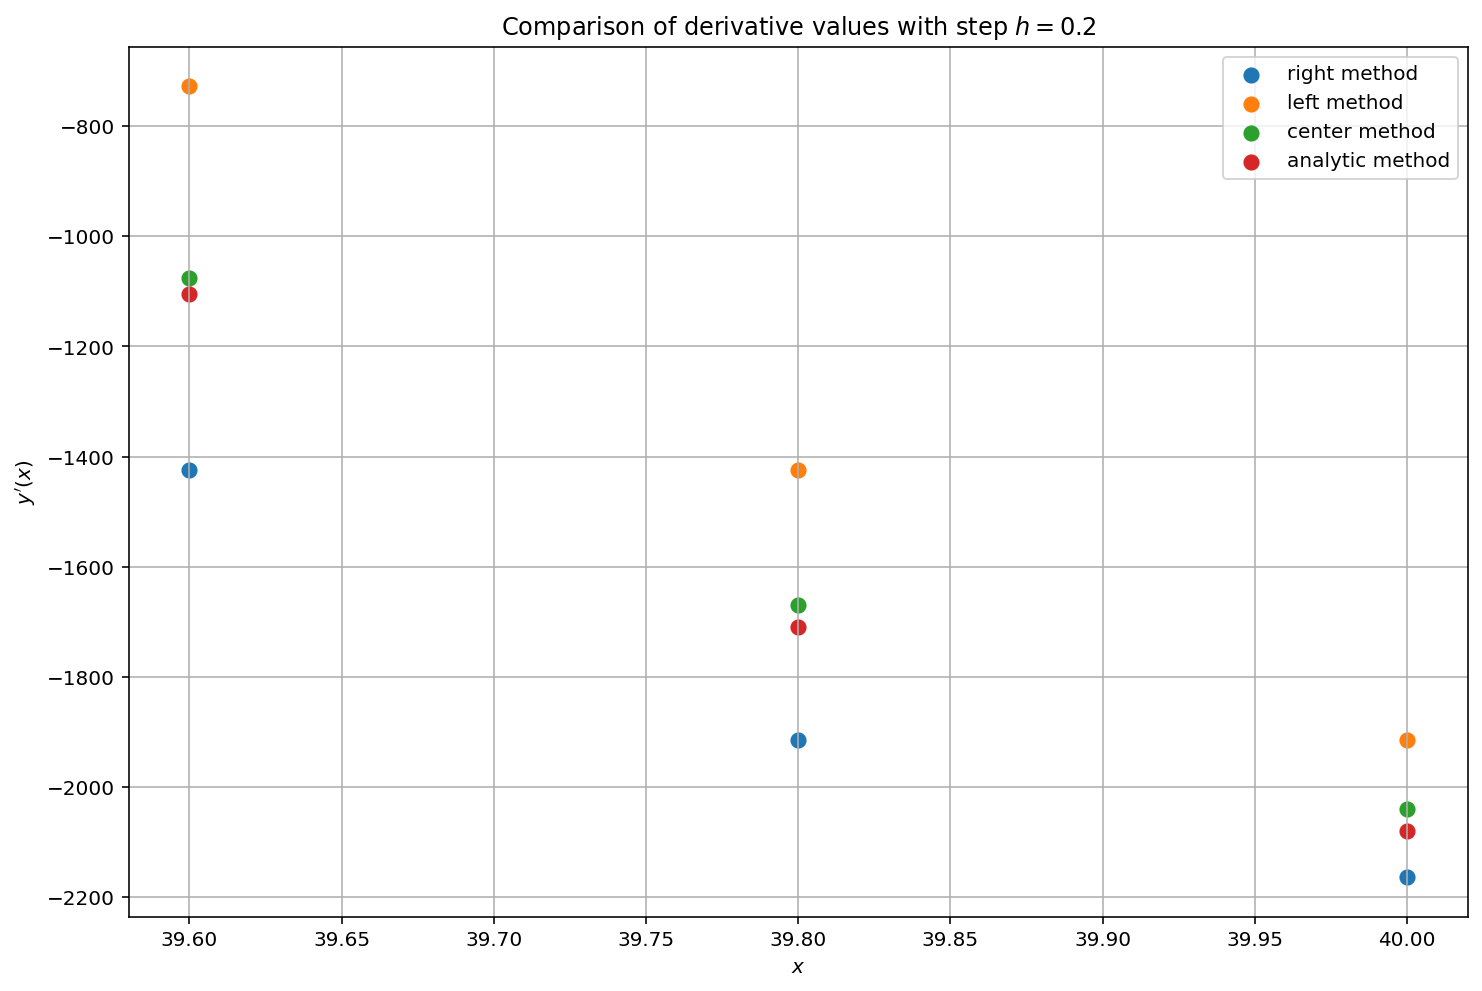

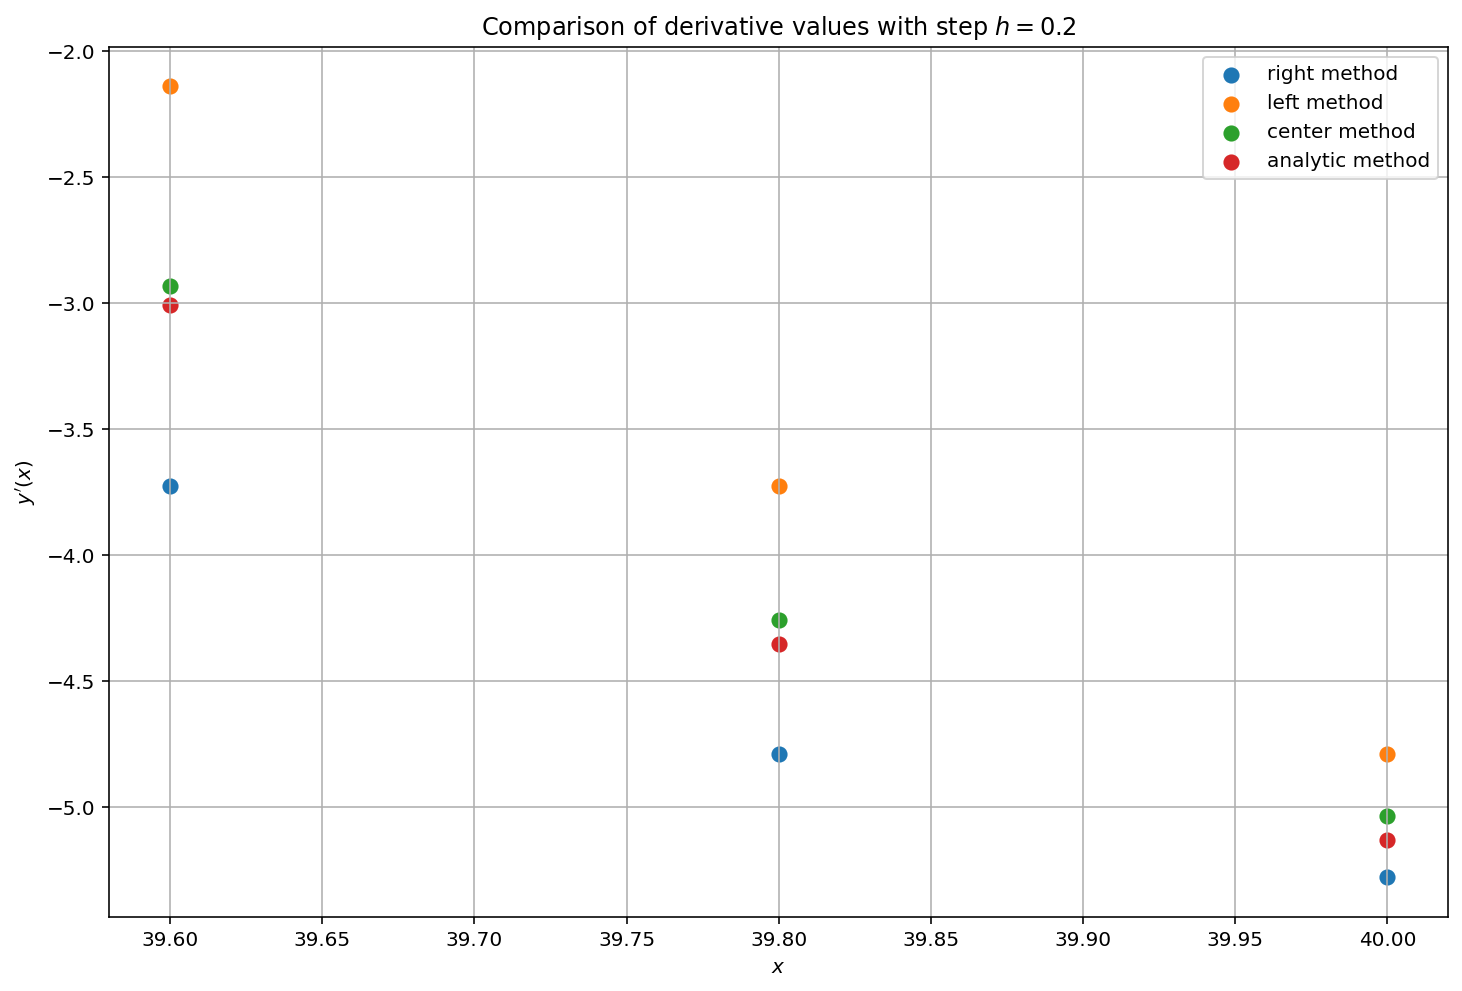

In [111]:
plot_compare([[rightdiff_first[-3:], "right"],
              [leftdiff_first[-3:], "left"],
              [diff_first[-3:], "center"],
              [analyticdiff_first[-3:], "analytic"]], argx[-3:], h)
plot_compare([[rightdiff_second[-3:], "right"],
              [leftdiff_second[-3:], "left"],
              [diff_second[-3:], "center"],
              [analyticdiff_second[-3:], "analytic"]], argx[-3:], h)

### **#3** ***Найдите среднеквадратичные отклонения численных от истинных значений производной.***

In [112]:
MSE_left_first = sum((x - a) ** 2 for x, a in zip(leftdiff_first, analyticdiff_first)) / len(analyticdiff_first)
MSE_right_first = sum((x - a) ** 2 for x, a in zip(rightdiff_first, analyticdiff_first)) / len(analyticdiff_first)
MSE_center_first = sum((x - a) ** 2 for x, a in zip(diff_first, analyticdiff_first)) / len(analyticdiff_first)
print(f"First function\nleft derivatives MSE: {MSE_left_first}\nright derivatives MSE: {MSE_right_first}\ncenter derivatives MSE: {MSE_center_first}")
MSE_left_second = sum((x - a) ** 2 for x, a in zip(leftdiff_second, analyticdiff_second)) / len(analyticdiff_second)
MSE_right_second = sum((x - a) ** 2 for x, a in zip(rightdiff_second, analyticdiff_second)) / len(analyticdiff_second)
MSE_center_second = sum((x - a) ** 2 for x, a in zip(diff_second, analyticdiff_second)) / len(analyticdiff_second)
print(f"Second function\nleft derivatives MSE: {MSE_left_second}\nright derivatives MSE: {MSE_right_second}\ncenter derivatives MSE: {MSE_center_second}")

First function
left derivatives MSE: 10827.738160508188
right derivatives MSE: 10842.866168225999
center derivatives MSE: 134.8970658232251
Second function
left derivatives MSE: 0.13857727707215356
right derivatives MSE: 0.13848179205066277
center derivatives MSE: 0.001742435117150265


### **#4** ***Выполните предыдущий пункт при уменьшении шага в 2, 4, 8 и 16. Постройте график зависимости среднеквадратичного отклонения от величины шага.***

In [113]:
def get_MSEs(n, func):
    argx_n = np.linspace(a, b, n * int((b - a) / h) + 1)
    analyticdiff_first_n = func_derivative_first(argx_n)
    analyticdiff_second_n = func_derivative_second(argx_n)
    MSE_right_first_n = sum((x - a) ** 2 for x, a in zip(get_rightdiff(func, argx_n, h / n), analyticdiff_first_n)) / len(analyticdiff_first_n)
    MSE_center_first_n = sum((x - a) ** 2 for x, a in zip(get_diff(func, argx_n, h / n), analyticdiff_first_n)) / len(analyticdiff_first_n)
    return [MSE_right_first_n, MSE_center_first_n]

Найдем СКО для значений шага, уменьшенных в 2, 4, 8 и 16 раз:

In [114]:
# first function, h / 2
MSE_right_first_2, MSE_center_first_2 = get_MSEs(2, func_first)
# first function, h / 4
MSE_right_first_4, MSE_center_first_4 = get_MSEs(4, func_first)
# first function, h / 8
MSE_right_first_8, MSE_center_first_8 = get_MSEs(8, func_first)
# first function, h / 16
MSE_right_first_16, MSE_center_first_16 = get_MSEs(16, func_first)

Построим значения среднеквадратичных ошибок от величины шага для первой функции для методов правой и центральной производной:

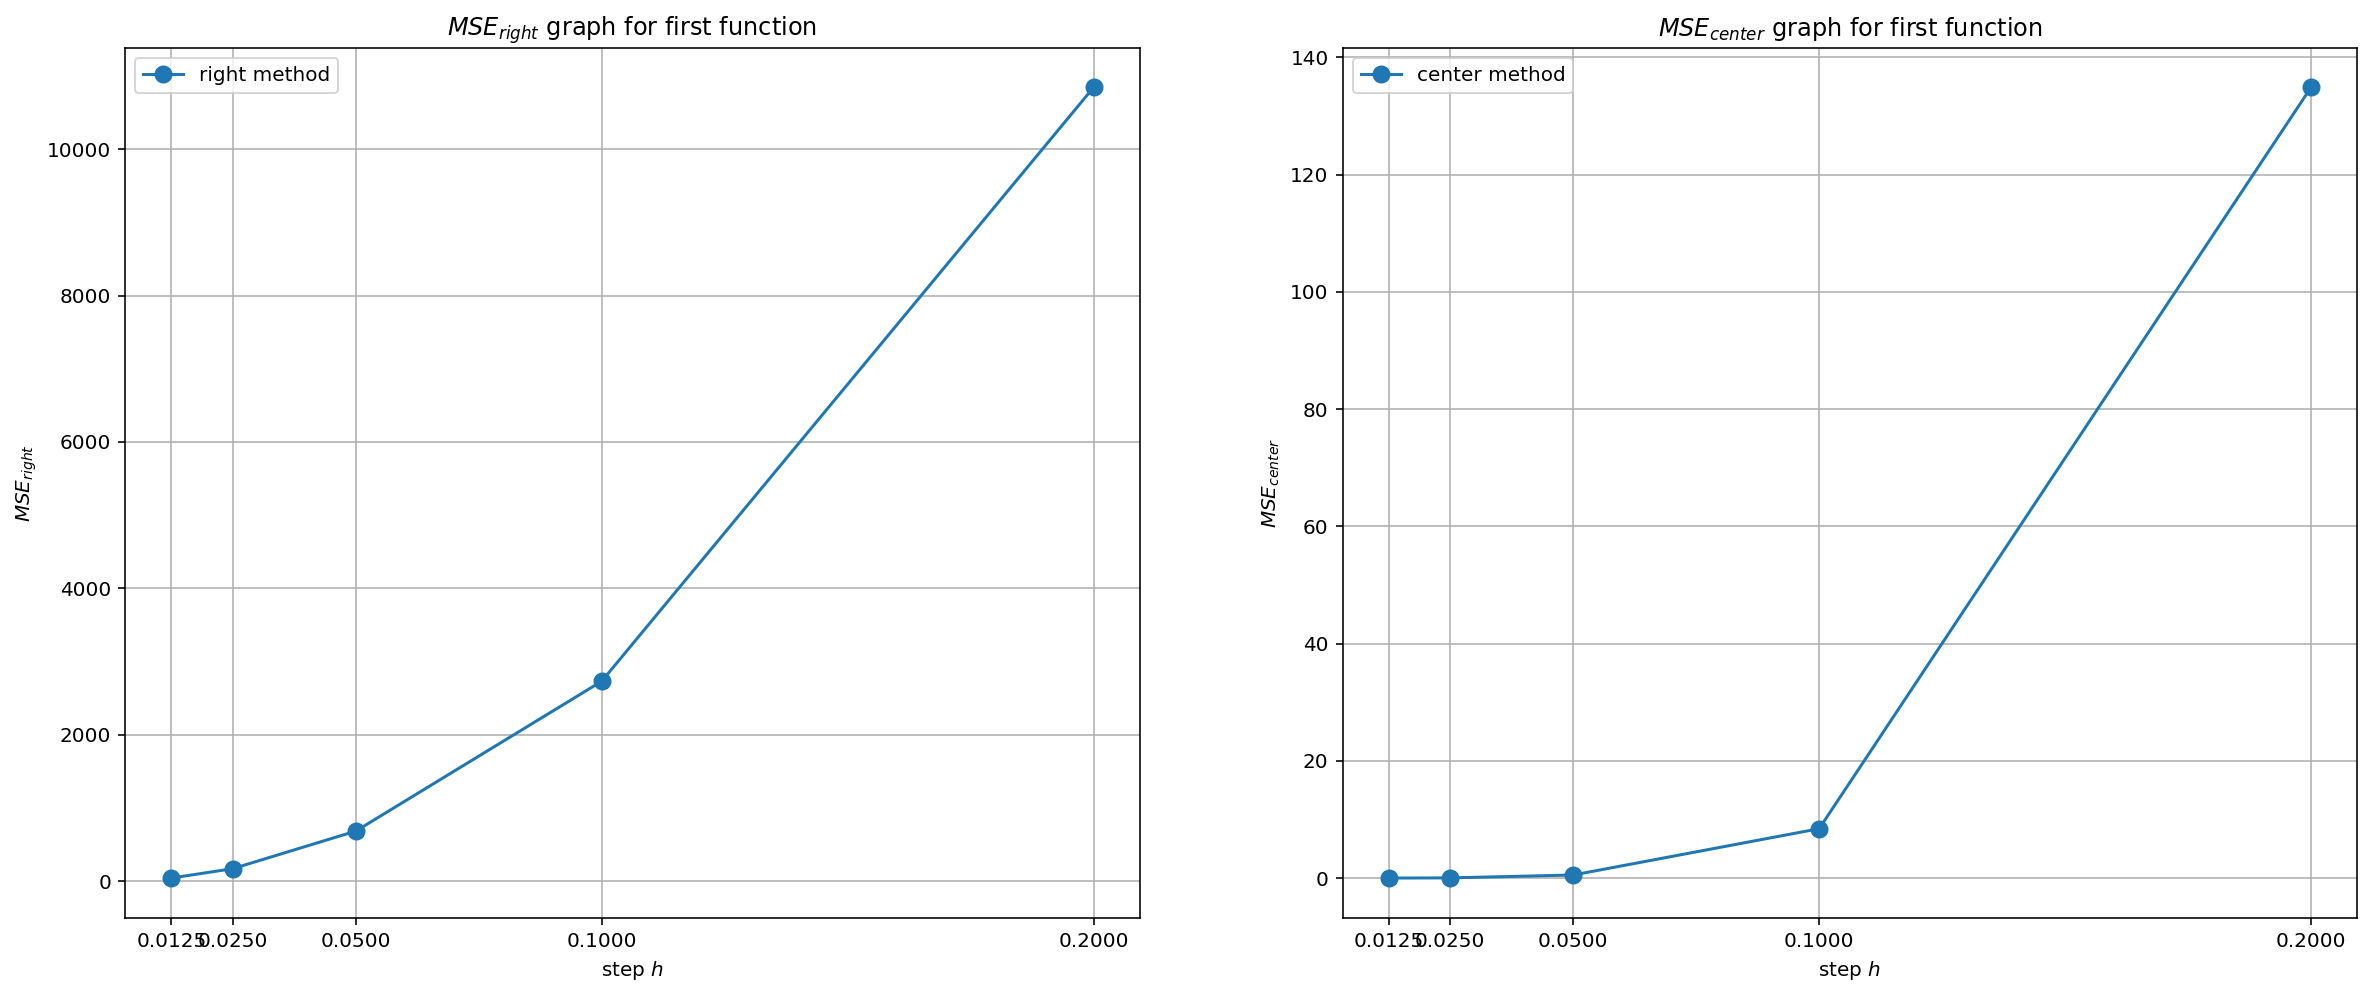

In [115]:
steps = [h / 2 ** i for i in range(5)]
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(steps,
           [MSE_right_first, MSE_right_first_2, MSE_right_first_4, MSE_right_first_8, MSE_right_first_16],
           'o-', label="right method",
           markersize=8)
ax[1].plot(steps,
           [MSE_center_first, MSE_center_first_2, MSE_center_first_4, MSE_center_first_8, MSE_center_first_16],
           'o-', label="center method", 
           markersize=8)
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()
ax[0].set(xlabel="step $h$", ylabel="$MSE_{right}$", title="$MSE_{right}$ graph for first function", xticks=steps)
ax[1].set(xlabel="step $h$", ylabel="$MSE_{center}$", title="$MSE_{center}$ graph for first function", xticks=steps)
plt.show()

Отсюда и получим подтверждение теоретических выкладок о квадратическом законе ограничения ошибки.

### **#5** ***Реализовать методы численного интегрирования.***

In [116]:
def get_leftsum(f, arguments, h):
    return sum(h * f(arg) for arg in arguments[:-1])

def get_rightsum(f, arguments, h):
    return sum(h * f(arg) for arg in arguments[1:])

def get_centersum(f, arguments, h):
    return sum(h * f((arguments[i] + arguments[i + 1]) / 2) for i in range(len(arguments) - 1))

def get_trapezoidsum(f, arguments, h):
    argf = [f(arg) for arg in arguments]
    return sum(h * (argf[i] + argf[i + 1]) / 2 for i in range(len(argf) - 1))

def get_parabolicsum(f, arguments, h):
    return sum(h * (f(arguments[i]) + f(arguments[i + 1]) + 4 * f((arguments[i] + arguments[i + 1]) / 2)) / 6 for i in range(len(arguments) - 1))

### **#6** ***Выберите 2 функции и вычислите для них определенный интеграл на отрезке. Сравните полученное значение с ответом, полученным аналитически.***

Введем следующие функции:

$f_1(x)=\cos\left(\frac{x}{10}\right)+2, \: \: x \in [10, 40]$

$f_2(x)=\sin(x)\cdot e^{\cos x}+10, \: \: x \in [10, 40]$

 будем рассматривать их на отрезке $x \in [10, 40]$

In [117]:
def function_1(x):
    return np.cos(x / 10) + 2

def function_2(x):
    return np.sin(x) * np.e ** np.cos(x) + 10

a, b = 10, 40

По Ньютону-Лейбницу выведем аналитически:

In [118]:
def sum_analytics_first(a, b):
    return (2 * b + 10 * np.sin(b / 10) - 2 * a - 10 * np.sin(a / 10))

def sum_analytics_second(a, b):
    return (10 * b - np.e ** np.cos(b) - 10 * a +  np.e ** np.cos(a))

Зафиксируем шаг и разбиение сетки:

In [119]:
h = 2e-1
argx = np.linspace(a, b, int((b - a) / h) + 1) 

Займемся расчетами интегралов по реализованным методам:

In [120]:
# first function
analytics_sum_first = sum_analytics_first(a, b)
left_sum_first = get_leftsum(function_1, argx, h)
right_sum_first = get_rightsum(function_1, argx, h)
center_sum_first = get_centersum(function_1, argx, h)
trapezoid_sum_first = get_trapezoidsum(function_1, argx, h)
parabolic_sum_first = get_parabolicsum(function_1, argx, h)
sums_first = [[analytics_sum_first, "absolute sums"],
              [center_sum_first, "center sums"],
              [trapezoid_sum_first, "trapezoid sums"],
              [parabolic_sum_first, "parabolic sums"]]

# second function
analytics_sum_second = sum_analytics_second(a, b)
left_sum_second = get_leftsum(function_2, argx, h)
right_sum_second = get_rightsum(function_2, argx, h)
center_sum_second = get_centersum(function_2, argx, h)
trapezoid_sum_second = get_trapezoidsum(function_2, argx, h)
parabolic_sum_second = get_parabolicsum(function_2, argx, h)
sums_second = [[analytics_sum_second, "absolute sums"],
              [center_sum_second, "center sums"],
              [trapezoid_sum_second, "trapezoid sums"],
              [parabolic_sum_second, "parabolic sums"]]

Выведем результаты подсчетов:

In [121]:
print(f"For first function:", *[f"{entry[1]}: {entry[0]}" for entry in sums_first], sep="\n")
print(f"For second function:", *[f"{entry[1]}: {entry[0]}" for entry in sums_second], sep="\n")

For first function:
absolute sums: 44.01726519884175
center sums: 44.016998816820625
trapezoid sums: 44.01779796022019
parabolic sums: 44.0172651979538
For second function:
absolute sums: 299.9188337411277
center sums: 299.9190622147571
trapezoid sums: 299.91837715144715
parabolic sums: 299.9188338603204


И для большего эффекта, нанесем на график близкие значения:

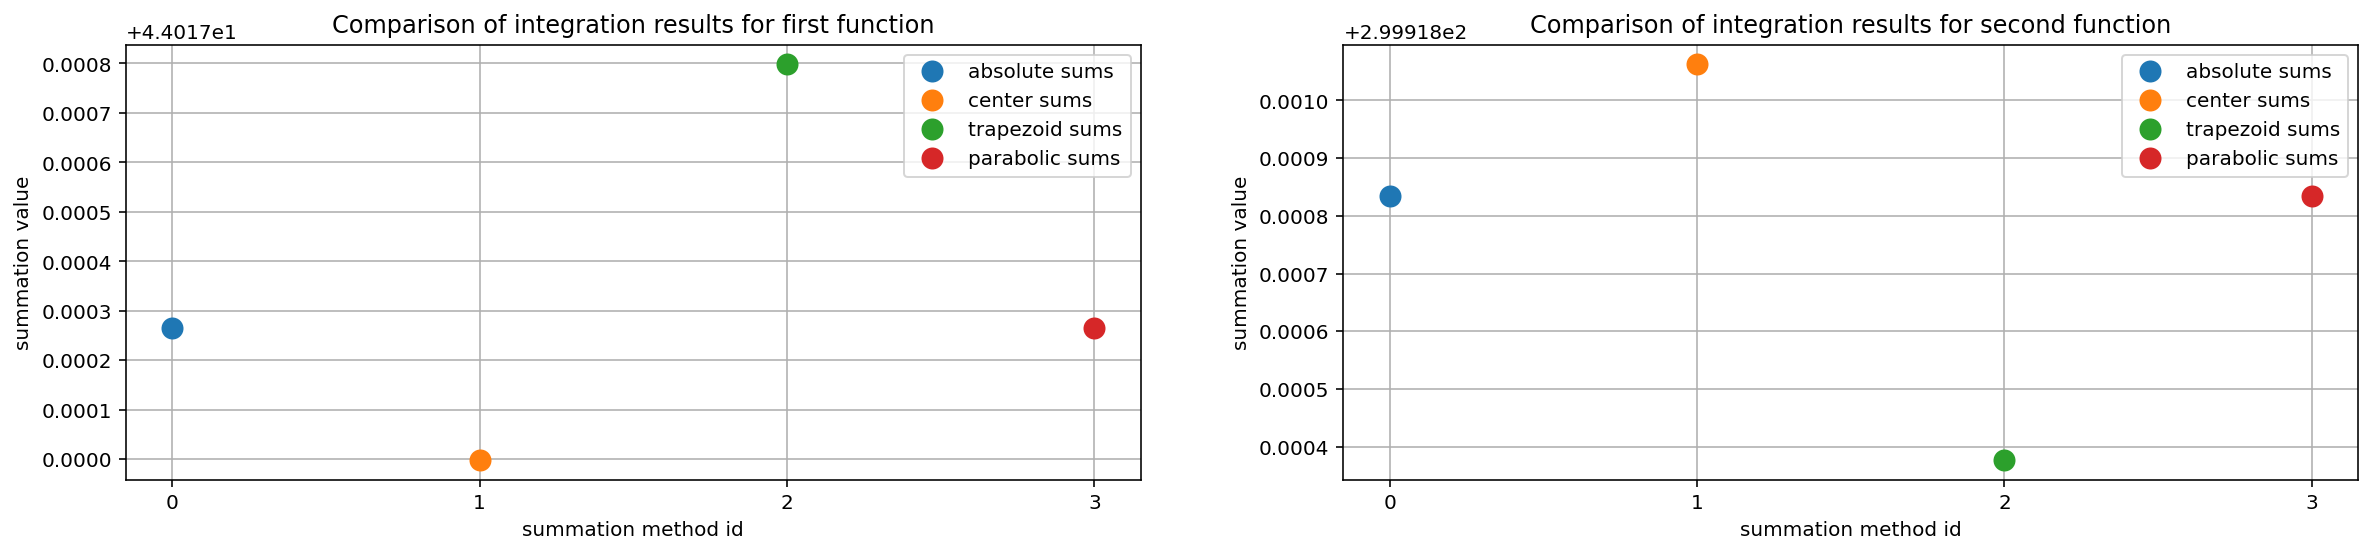

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
for i in range(len(sums_first)):
    ax[0].plot(i, sums_first[i][0], 'o', label=sums_first[i][1], markersize=10)
ax[0].grid()
ax[0].legend()
ax[0].set(xticks=np.arange(0, len(sums_first)), xlabel="summation method id", ylabel="summation value", title="Comparison of integration results for first function")
for i in range(len(sums_second)):
    ax[1].plot(i, sums_second[i][0], 'o', label=sums_second[i][1], markersize=10)
ax[1].grid()
ax[1].legend()
ax[1].set(xticks=np.arange(0, len(sums_second)), xlabel="summation method id", ylabel="summation value", title="Comparison of integration results for second function")
plt.show()

### **#7** ***Проанализируйте зависимость отклонения численного ответа от аналитического в зависимости от шага при уменьшении его в 2, 4, 8 и 16 раз. Постройте график зависимости отклонения от величины шага.***

In [123]:
def get_deviations(lst_n, sum_method, function, value_analytics):
    return [abs(sum_method(function, np.linspace(a, b, n * int((b - a) / h) + 1), h / n) - value_analytics(a, b)) for n in lst_n]

Составим массив всех отклонений по каждом методу и для каждого значения шага для обеих функций:

In [124]:
ns = [2, 4, 8, 16]
deviations = [[[get_deviations(ns, get_centersum, function_1, sum_analytics_first), "center sums"],
               [get_deviations(ns, get_trapezoidsum, function_1, sum_analytics_first), "trapezoid sums"],
               [get_deviations(ns, get_parabolicsum, function_1, sum_analytics_first), "parabolic sums"]],
              [[get_deviations(ns, get_centersum, function_2, sum_analytics_second), "center sums"],
               [get_deviations(ns, get_trapezoidsum, function_2, sum_analytics_second), "trapezoid sums"],
               [get_deviations(ns, get_parabolicsum, function_2, sum_analytics_second), "parabolic sums"]]]

Построим зависимости отклонения (посчитанных численными методами значений интегральных сумм от аналитически выведденого значения) от шага разбиения сетки для каждого метода подсчета:

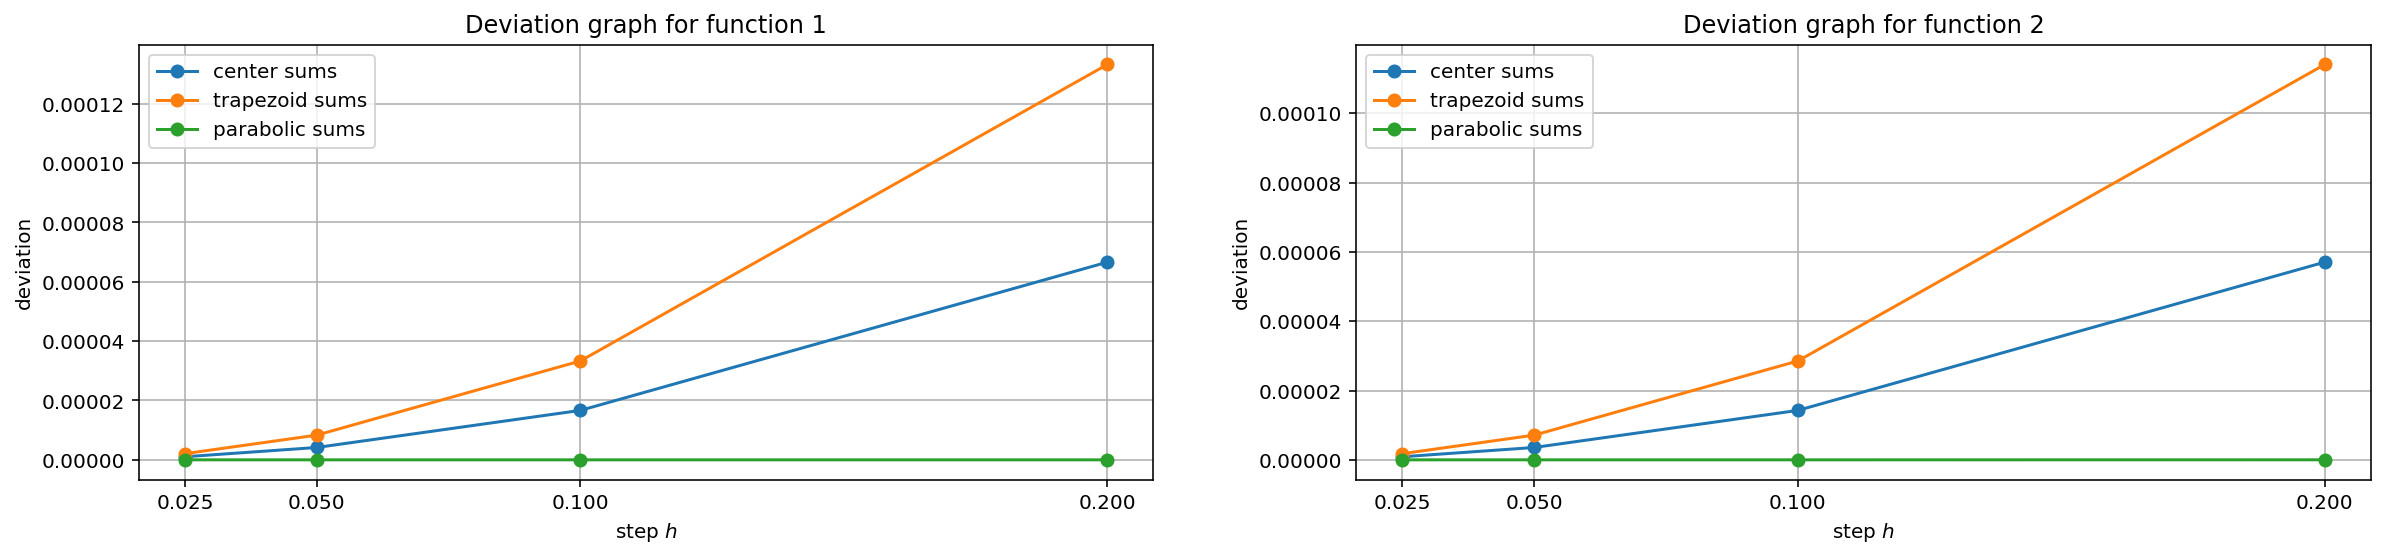

In [125]:
steps = [h / 2 ** i for i in range(4)]
fig, ax = plt.subplots(1, len(deviations), figsize=(20, 4))
for dev_i in range(len(deviations)):
    for method in deviations[dev_i]:
        ax[dev_i].plot(steps, method[0], 'o-', label=method[1])
    ax[dev_i].grid()
    ax[dev_i].legend()
    ax[dev_i].set(xlabel="step $h$", ylabel="deviation",
                  title=f"Deviation graph for function {dev_i + 1}",
                  xticks=steps)
plt.show()